In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
import xgboost as xgb
from xgboost import XGBRegressor
import shap
import time
import psutil
import warnings
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')


# Mount Google Drive
drive.mount('/content/drive')


# Load data
macro_folder = '/content/drive/MyDrive/processed_data'
financial_folder = '/content/drive/MyDrive/financial_info'

# Load data with proper handling
def load_country_data(country_name):
    # Define file paths based on country name (lowercase for consistency)
    country_lower = country_name.lower()
    stock_file = f'{financial_folder}/{country_lower}_stock.csv'
    macro_file = f'{macro_folder}/{country_lower}_macro.csv'

    # Load stock data - skip ticker symbol row (row 1)
    stock_df = pd.read_csv(stock_file, parse_dates=['Date'], skiprows=[1])

    # Load macro data
    macro_df = pd.read_csv(macro_file, parse_dates=['date'])

    print(f"Loaded {country_name} data: {stock_df.shape[0]} stock rows, {macro_df.shape[0]} macro rows")

    return stock_df, macro_df

# Process each country's data
countries = ['brazil', 'india', 'south_africa']
country_dfs = {}

for country in countries:
    stock_df, macro_df = load_country_data(country)
    country_dfs[country] = (stock_df, macro_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded brazil data: 148 stock rows, 52 macro rows
Loaded india data: 148 stock rows, 52 macro rows
Loaded south_africa data: 148 stock rows, 52 macro rows


In [52]:
# Display Random Forest characteristics
rf_characteristics = {
    'Algorithm Type': 'Bagging (Bootstrap Aggregating)',
    'Model Building': 'Independent trees built on bootstrap samples',
    'Training Speed': 'Faster due to parallel processing',
    'Prediction Speed': 'Fast',
    'Handling Imbalanced Data': 'Moderate',
    'Handling Missing Values': 'Built-in handling via surrogate splits',
    'Feature Selection': 'Built-in, provides feature importance',
    'Hyperparameter Sensitivity': 'Less sensitive, easier to tune',
    'Overfitting Risk': 'Lower due to averaging of multiple trees',
    'Regularization': 'Implicit through randomization',
    'Memory Usage': 'Higher, storing many trees'
}

pd.DataFrame([rf_characteristics]).T.rename(columns={0: 'Characteristic'})

Characteristic
Algorithm Type                           Bagging (Bootstrap Aggregating)
Model Building              Independent trees built on bootstrap samples
Training Speed                         Faster due to parallel processing
Prediction Speed                                                    Fast
Handling Imbalanced Data                                        Moderate
Handling Missing Values           Built-in handling via surrogate splits
Feature Selection                  Built-in, provides feature importance
Hyperparameter Sensitivity                Less sensitive, easier to tune
Overfitting Risk                Lower due to averaging of multiple trees
Regularization                            Implicit through randomization
Memory Usage                                  Higher, storing many trees

In [53]:
# Display XGBoost characteristics
xgb_characteristics = {
    'Algorithm Type': 'Boosting (Sequential ensemble)',
    'Model Building': 'Sequential trees that correct previous errors',
    'Training Speed': 'Slower due to sequential nature',
    'Prediction Speed': 'Fast',
    'Handling Imbalanced Data': 'Better',
    'Handling Missing Values': 'Built-in handling via sparsity-aware split finding',
    'Feature Selection': 'Built-in, provides feature importance',
    'Hyperparameter Sensitivity': 'More sensitive, requires careful tuning',
    'Overfitting Risk': 'Higher, requires regularization',
    'Regularization': 'Explicit (L1, L2) requiring parameter tuning',
    'Memory Usage': 'Lower, more efficient data structures'
}

pd.DataFrame([xgb_characteristics]).T.rename(columns={0: 'Characteristic'})

Characteristic
Algorithm Type                                 Boosting (Sequential ensemble)
Model Building                  Sequential trees that correct previous errors
Training Speed                                Slower due to sequential nature
Prediction Speed                                                         Fast
Handling Imbalanced Data                                               Better
Handling Missing Values     Built-in handling via sparsity-aware split fin...
Feature Selection                       Built-in, provides feature importance
Hyperparameter Sensitivity            More sensitive, requires careful tuning
Overfitting Risk                              Higher, requires regularization
Regularization                   Explicit (L1, L2) requiring parameter tuning
Memory Usage                            Lower, more efficient data structures

In [54]:
def preprocess_country_data(stock_df, macro_df, country_name):
    # Create copies to avoid modifying original data
    stock_df = stock_df.copy()
    macro_df = macro_df.copy()

    # Standardize all column names to lowercase
    stock_df.columns = [col.lower() for col in stock_df.columns]
    macro_df.columns = [col.lower() for col in macro_df.columns]

    # Ensure date column is properly named
    if 'date' not in stock_df.columns and 'Date' in stock_df.columns:
        stock_df = stock_df.rename(columns={'Date': 'date'})

    # Convert close price to numeric, handling any non-numeric values
    if 'close' in stock_df.columns:
        stock_df['close'] = pd.to_numeric(stock_df['close'], errors='coerce')

    # Calculate returns and volatility
    stock_df['return_1m'] = stock_df['close'].pct_change(1)
    stock_df['return_3m'] = stock_df['close'].pct_change(3)
    stock_df['volatility'] = stock_df['return_1m'].rolling(20).std()

    # Remove duplicated columns (keep only columns without suffix)
    # This is critical for handling the triplicated columns in macro data
    macro_cols_to_keep = [col for col in macro_df.columns
                         if not col.endswith('_x') and not col.endswith('_y') and col != 'date']

    # Keep only unique columns
    macro_df = macro_df[['date'] + macro_cols_to_keep]

    # Convert all macro columns to numeric
    for col in macro_cols_to_keep:
        macro_df[col] = pd.to_numeric(macro_df[col], errors='coerce')

    # Sort dataframes by date before merging
    stock_df = stock_df.sort_values('date')
    macro_df = macro_df.sort_values('date')

    # Forward fill missing values in macro data
    # This is crucial for time series data with occasional missing values
    macro_df = macro_df.set_index('date')
    macro_df = macro_df.ffill()  # Forward fill
    macro_df = macro_df.reset_index()

    # Merge stock and macro data (using merge_asof for time series data)
    df = pd.merge_asof(stock_df, macro_df, on='date')

    # Calculate percentage changes for macro columns
    for col in macro_cols_to_keep:
        if col in df.columns:
            df[f'{col}_change'] = df[col].pct_change(1).fillna(0)  # Fill NaN from pct_change with 0

    df['country'] = country_name
    return df

# Process and combine data
processed_dfs = {}
for country in countries:
    stock_df, macro_df = country_dfs[country]
    processed_dfs[country] = preprocess_country_data(stock_df, macro_df, country)

combined_df = pd.concat(list(processed_dfs.values()))


In [55]:
def define_market_regime(df):
    # Create a copy to avoid modifying the original
    df_copy = df.copy()

    # Only calculate regimes based on rows with valid return and volatility
    mask = df_copy['return_1m'].notna() & df_copy['volatility'].notna()
    valid_data = df_copy[mask]

    # Calculate quantiles only on valid data
    return_high = valid_data['return_1m'].quantile(0.7)
    return_low = valid_data['return_1m'].quantile(0.3)
    vol_high = valid_data['volatility'].quantile(0.7)

    # Define conditions for regimes (0: Bear, 1: Sideways, 2: Bull)
    conditions = [
        (df_copy['return_1m'] < return_low) & (df_copy['volatility'] > vol_high),
        (df_copy['return_1m'] >= return_low) & (df_copy['return_1m'] <= return_high),
        (df_copy['return_1m'] > return_high)
    ]
    choices = [0, 1, 2]

    # Apply conditions to create regime column
    df_copy['regime'] = np.select(conditions, choices, default=1)

    return df_copy

# Define market regimes
combined_df = define_market_regime(combined_df)



In [56]:
# Select features with lowercase names to match preprocessed data
features = ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi',
            'exchange_rate', 'imports', 'exports', 'gdp_change',
            'cpi_change', 'imports_change', 'exports_change']

# Keep only features that exist in the dataset
available_features = [f for f in features if f in combined_df.columns]

# Fill missing values in features to prevent excessive data loss
for feature in available_features:
    if feature.endswith('_change'):
        # Fill NaN in percentage change features with 0
        combined_df[feature] = combined_df[feature].fillna(0)
    else:
        # Forward fill other features
        combined_df[feature] = combined_df[feature].ffill()

# Prepare clean dataset for modeling
X = combined_df[available_features].dropna()
y = combined_df.loc[X.index, 'regime']

# Use TimeSeriesSplit instead of regular train_test_split to prevent data leakage
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Get the last split for final evaluation
train_indices = []
test_indices = []

for train_index, test_index in tscv.split(X):
    train_indices = train_index
    test_indices = test_index

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [57]:
# Initialize models
models = {
    'RF-100': RandomForestRegressor(n_estimators=100, random_state=42),
    'RF-200': RandomForestRegressor(n_estimators=200, random_state=42),
    'RF-500': RandomForestRegressor(n_estimators=500, random_state=42),
    'XGB-100': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGB-200': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

# Stratified k-fold cross-validation
k_values = [3, 5, 7]
cv_results = {}

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_results[k] = {}

    for name, model in models.items():
        r2_scores = cross_val_score(model, X_train_scaled, y_train,
                                   cv=skf, scoring='r2')
        cv_results[k][name] = {
            'r2_mean': r2_scores.mean(),
            'r2_std': r2_scores.std()
        }

# Train models and collect metrics
train_results = {}
test_results = {}
training_times = {}
memory_usage = {}
feature_importances = {}

for name, model in models.items():
    # Measure training time and memory
    mem_before = psutil.virtual_memory().percent
    start_time = time.time()

    model.fit(X_train_scaled, y_train)

    training_times[name] = time.time() - start_time
    mem_after = psutil.virtual_memory().percent
    memory_usage[name] = mem_after - mem_before

    # Store feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = dict(zip(available_features, model.feature_importances_))

    # Predictions - round for classification metrics
    y_train_pred = np.round(model.predict(X_train_scaled)).astype(int)
    y_test_pred = np.round(model.predict(X_test_scaled)).astype(int)

    # Training metrics
    train_results[name] = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, average='weighted'),
        'recall': recall_score(y_train, y_train_pred, average='weighted'),
        'f1': f1_score(y_train, y_train_pred, average='weighted')
    }

    # Test metrics
    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }


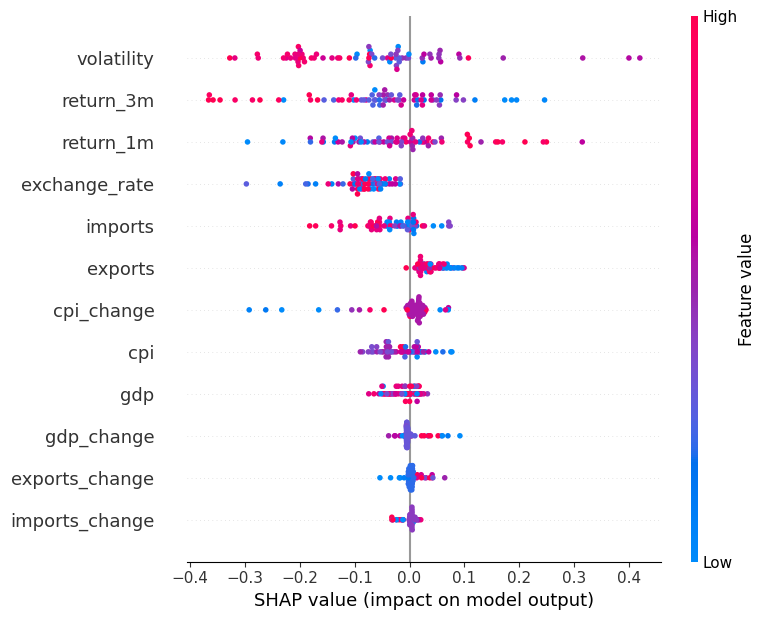

<Figure size 640x480 with 0 Axes>

In [58]:
# Generate SHAP values for the best model
explainer = shap.TreeExplainer(models['XGB-200'])
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=available_features)
plt.tight_layout()
plt.show()


In [68]:
def display_model_results(models, feature_importances, train_results, test_results,
                         training_times, memory_usage, cv_results=None, features=None):
    """
    Display the results of model comparison in tabular format.

    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    feature_importances : dict
        Dictionary of feature importance values for each model
    train_results : dict
        Dictionary of training set metrics for each model
    test_results : dict
        Dictionary of test set metrics for each model
    training_times : dict
        Dictionary of training times for each model
    memory_usage : dict
        Dictionary of memory usage for each model
    cv_results : dict, optional
        Dictionary of cross-validation results for different k values
    features : list, optional
        List of feature names
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Table 1: Feature Importance
    print("Table 1: Feature Importance")
    # Choose the best model for feature importance (e.g., XGB-200)
    best_model = 'XGB-200'
    if best_model in feature_importances:
        feature_imp = feature_importances[best_model]
        importance_df = pd.DataFrame({
            'Feature': list(feature_imp.keys()),
            'Importance': list(feature_imp.values())
        }).sort_values('Importance', ascending=False)
        print(importance_df.to_string(index=False))

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Feature Importance for Market Regime Classification', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("Feature importance not available for selected model")

    print("\n")

    # Table 2: Training Set Performance Metrics
    print("Table 2: Training Set Performance Metrics")
    train_df = pd.DataFrame({
        model: {metric: value for metric, value in results.items()}
        for model, results in train_results.items()
    }).T
    print(train_df.round(4))

    print("\n")

    # Table 3: Test Set Performance Metrics
    print("Table 3: Test Set Performance Metrics")
    test_df = pd.DataFrame({
        model: {metric: value for metric, value in results.items()}
        for model, results in test_results.items()
    }).T
    print(test_df.round(4))

    print("\n")

    # Table 4: Overfitting Analysis (|Train - Test|)
    print("Table 4: Overfitting Analysis (|Train - Test|)")
    overfitting_df = pd.DataFrame(index=train_df.index, columns=train_df.columns)
    for model in train_df.index:
        for metric in train_df.columns:
            overfitting_df.loc[model, metric] = abs(train_df.loc[model, metric] - test_df.loc[model, metric])
    print(overfitting_df.round(4))

    print("\n")

    # Table 5: Training Time
    print("Table 5: Training Time (seconds)")
    time_df = pd.DataFrame.from_dict(training_times, orient='index', columns=['Training Time'])
    print(time_df.round(2))

    print("\n")

    # Table 6: RAM Usage
    print("Table 6: RAM Usage (% increase)")
    ram_df = pd.DataFrame.from_dict(memory_usage, orient='index', columns=['RAM Usage'])
    print(ram_df.round(2))

    # Table 7: Cross-Validation Results (if available)
    if cv_results:
        print("\n")
        print("Table 7: Cross-Validation Results (R² Score)")

        for k, cv_result in cv_results.items():
            print(f"\nk={k} fold cross-validation:")
            cv_df = pd.DataFrame({
                model: {
                    'R² Mean': results['r2_mean'],
                    'R² Std': results['r2_std']
                } for model, results in cv_result.items()
            }).T
            print(cv_df.round(4))

        # Plot CV results
        plt.figure(figsize=(12, 6))
        for k in cv_results.keys():
            r2_means = [cv_results[k][model]['r2_mean'] for model in models.keys()]
            plt.plot(models.keys(), r2_means, marker='o', label=f'{k}-fold CV')
        plt.title('Cross-Validation R² Scores by Model')
        plt.xlabel('Model')
        plt.ylabel('R² Score')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot train vs test accuracy
    plt.figure(figsize=(12, 6))
    model_names = list(models.keys())
    train_acc = [train_results[m]['accuracy'] for m in model_names]
    test_acc = [test_results[m]['accuracy'] for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, train_acc, width, label='Train Accuracy')
    plt.bar(x + width/2, test_acc, width, label='Test Accuracy')
    plt.xticks(x, model_names)
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy by Model')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [62]:
# Display training results
train_df = pd.DataFrame({
    model: {metric: value for metric, value in results.items()}
    for model, results in train_results.items()
}).T
print("Training Set Performance Metrics:")
print(train_df.round(4))

Training Set Performance Metrics:
         accuracy  precision  recall      f1
RF-100     0.9632     0.9653  0.9632  0.9596
RF-200     0.9717     0.9729  0.9717  0.9710
RF-500     0.9773     0.9782  0.9773  0.9763
XGB-100    0.9943     0.9944  0.9943  0.9943
XGB-200    0.9972     0.9972  0.9972  0.9972


In [63]:
# Display test results
test_df = pd.DataFrame({
    model: {metric: value for metric, value in results.items()}
    for model, results in test_results.items()
}).T
print("Test Set Performance Metrics:")
print(test_df.round(4))

Test Set Performance Metrics:
         accuracy  precision  recall      f1
RF-100     0.7857     0.6173  0.7857  0.6914
RF-200     0.7857     0.6173  0.7857  0.6914
RF-500     0.7857     0.6173  0.7857  0.6914
XGB-100    0.7714     0.6333  0.7714  0.6956
XGB-200    0.7571     0.6215  0.7571  0.6827


In [64]:
# Calculate overfitting metrics
overfitting_df = pd.DataFrame(index=train_df.index, columns=train_df.columns)
for model in train_df.index:
    for metric in train_df.columns:
        overfitting_df.loc[model, metric] = abs(train_df.loc[model, metric] - test_df.loc[model, metric])
print("Overfitting Analysis (|Train - Test|):")
print(overfitting_df.round(4))


Overfitting Analysis (|Train - Test|):
         accuracy precision    recall        f1
RF-100   0.177459  0.347926  0.177459  0.268199
RF-200   0.185957  0.355583  0.185957  0.279546
RF-500   0.191623  0.360803  0.191623  0.284847
XGB-100  0.222906  0.361124  0.222906   0.29877
XGB-200  0.240024  0.375645  0.240024  0.314494


In [65]:
# Display training times
time_df = pd.DataFrame.from_dict(training_times, orient='index', columns=['Training Time (seconds)'])
print("Training Time (seconds):")
print(time_df.round(2))


Training Time (seconds):
         Training Time (seconds)
RF-100                      0.37
RF-200                      0.70
RF-500                      1.80
XGB-100                     0.14
XGB-200                     0.24


In [66]:
# Display RAM usage
ram_df = pd.DataFrame.from_dict(memory_usage, orient='index', columns=['RAM Usage (% increase)'])
print("RAM Usage (% increase):")
print(ram_df.round(2))


RAM Usage (% increase):
         RAM Usage (% increase)
RF-100                      0.0
RF-200                      0.0
RF-500                      0.0
XGB-100                     0.0
XGB-200                     0.0


Table 1: Feature Importance
       Feature  Importance
           gdp    0.130922
       exports    0.124958
 exchange_rate    0.124426
    cpi_change    0.106629
           cpi    0.093274
    volatility    0.087766
       imports    0.072885
exports_change    0.067942
     return_3m    0.061037
     return_1m    0.048220
    gdp_change    0.046683
imports_change    0.035258


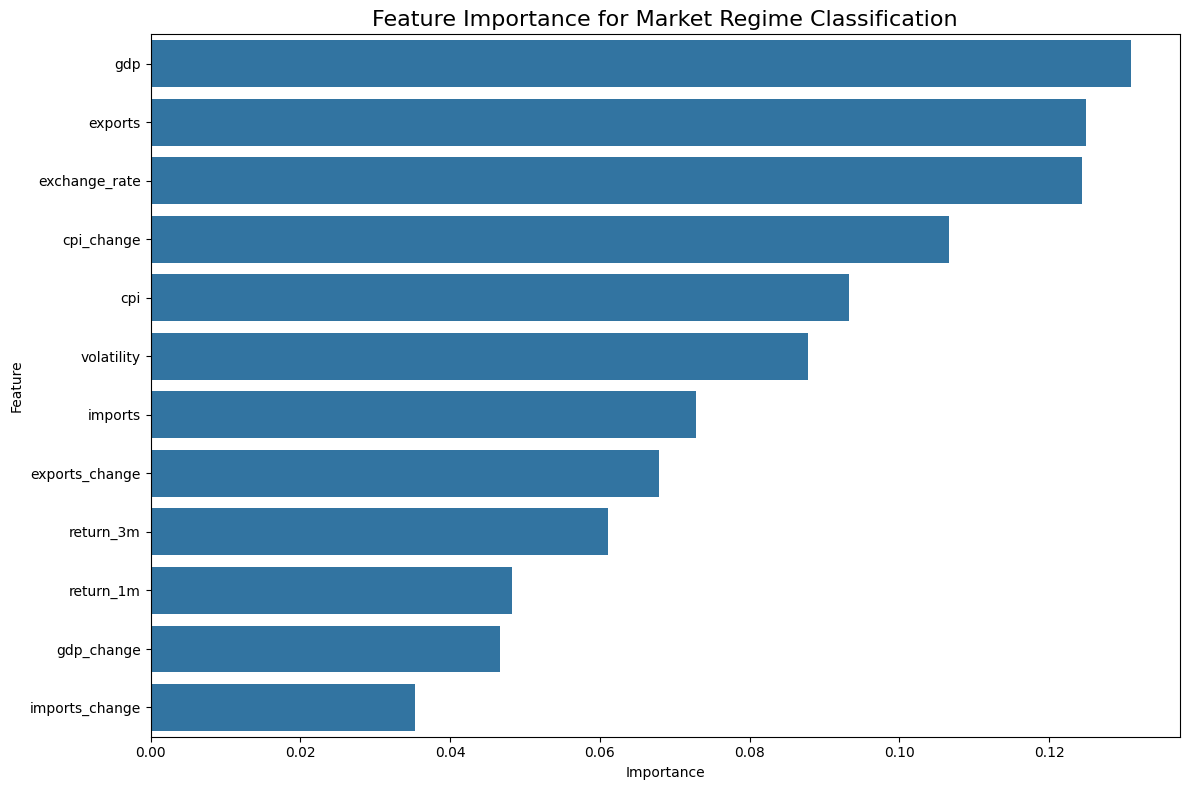



Table 2: Training Set Performance Metrics
         accuracy  precision  recall      f1
RF-100     0.9632     0.9653  0.9632  0.9596
RF-200     0.9717     0.9729  0.9717  0.9710
RF-500     0.9773     0.9782  0.9773  0.9763
XGB-100    0.9943     0.9944  0.9943  0.9943
XGB-200    0.9972     0.9972  0.9972  0.9972


Table 3: Test Set Performance Metrics
         accuracy  precision  recall      f1
RF-100     0.7857     0.6173  0.7857  0.6914
RF-200     0.7857     0.6173  0.7857  0.6914
RF-500     0.7857     0.6173  0.7857  0.6914
XGB-100    0.7714     0.6333  0.7714  0.6956
XGB-200    0.7571     0.6215  0.7571  0.6827


Table 4: Overfitting Analysis (|Train - Test|)
         accuracy precision    recall        f1
RF-100   0.177459  0.347926  0.177459  0.268199
RF-200   0.185957  0.355583  0.185957  0.279546
RF-500   0.191623  0.360803  0.191623  0.284847
XGB-100  0.222906  0.361124  0.222906   0.29877
XGB-200  0.240024  0.375645  0.240024  0.314494


Table 5: Training Time (seconds)
    

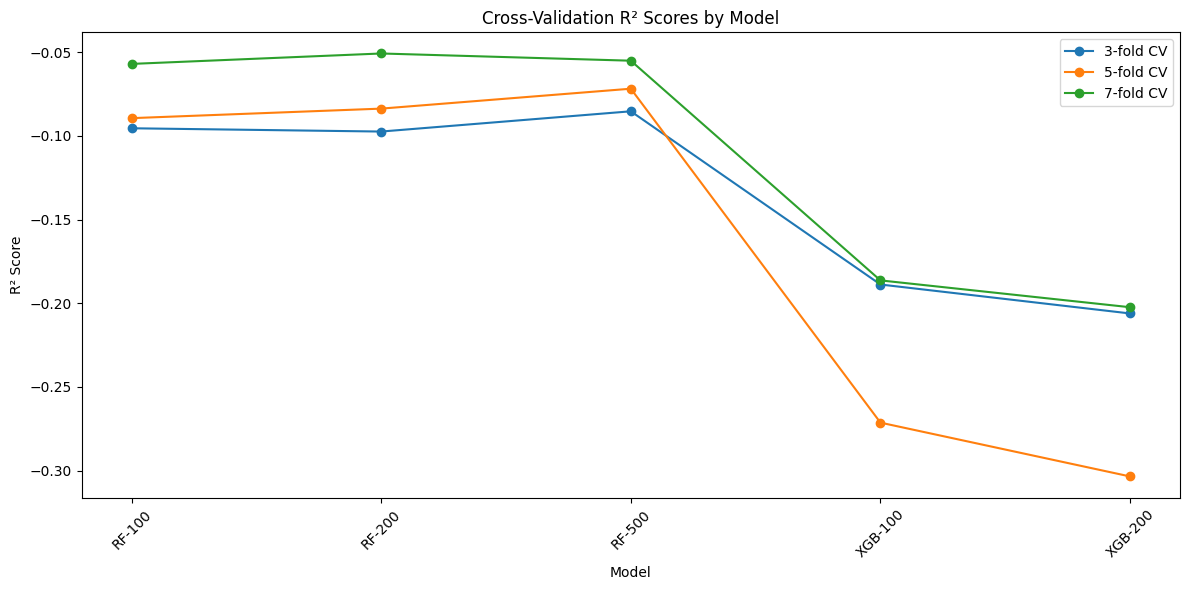

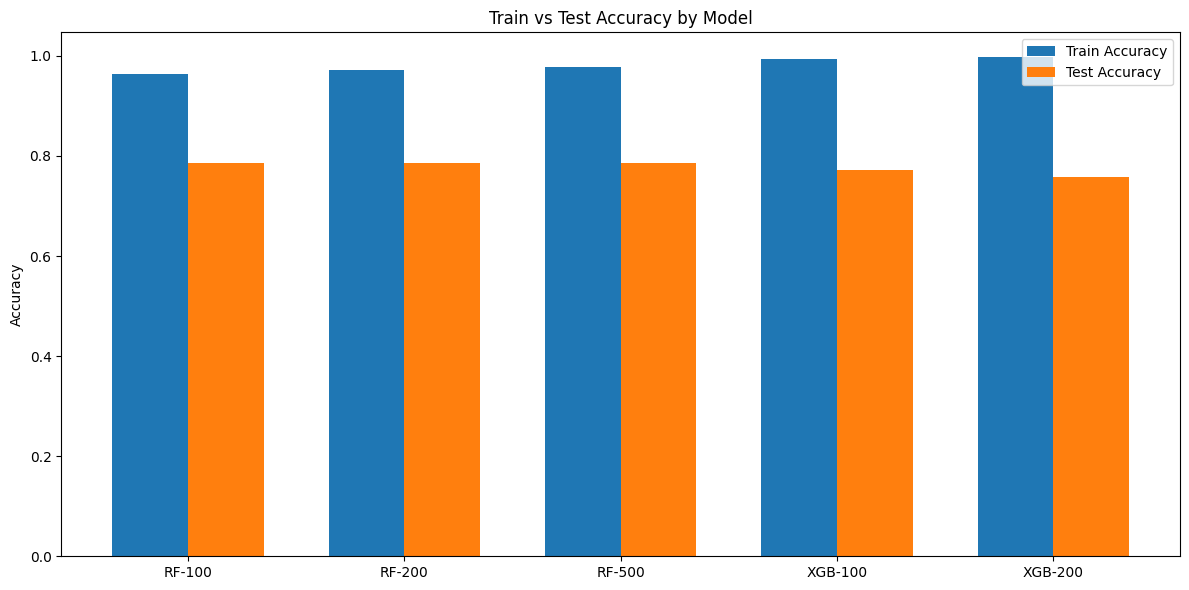

In [60]:
# Example usage after training models and collecting metrics
display_model_results(
    models=models,
    feature_importances=feature_importances,
    train_results=train_results,
    test_results=test_results,
    training_times=training_times,
    memory_usage=memory_usage,
    cv_results=cv_results,
    features=available_features
)
